# **DATASET PREPAPARATION**

In [ ]:
# Install Roboflow untuk Download dataset
! pip install Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
# Download dataset dari Project di Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="NqMSpG0TwEe3h0vlKWD8")
project = rf.workspace("persotrak").project("face-mask-aq2sw-rwuxg")
dataset = project.version(1).download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to face-mask-1 in yolov11:: 100%|██████████| 18466/18466 [00:02<00:00, 7502.71it/s]


In [ ]:
# Standard Libraries
import os
import random
import time
import shutil
from pathlib import Path

# Data Manipulation and Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Computer Vision
import cv2

# Machine Learning (Data Splitting)
from sklearn.model_selection import train_test_split

# Configuration and File I/O
import yaml

# Ultralytics YOLO (Object Detection)
! pip install ultralytics
import ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **EXPLORATORY DATASET ANALYSIST**

In [ ]:
dataset_path = Path('face-mask-1')

def count_images(directory):
    count = 0
    if directory.exists() and directory.is_dir():
        for file in directory.iterdir():
            if file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
                count += 1
    return count

train_images_path = dataset_path / 'train' / 'images'
valid_images_path = dataset_path / 'valid' / 'images'
test_images_path = dataset_path / 'test' / 'images'

train_count = count_images(train_images_path)
valid_count = count_images(valid_images_path)
test_count = count_images(test_images_path)

print(f"Number of images in 'train' dataset: {train_count}")
print(f"Number of images in 'valid' dataset: {valid_count}")
print(f"Number of images in 'test' dataset: {test_count}")

Number of images in 'train' dataset: 6445
Number of images in 'valid' dataset: 1872
Number of images in 'test' dataset: 910


In [ ]:
def calculate_dhash(image_path):
    """
    Calculates the dHash (difference hash) for a given image file.

    Args:
        image_path (str): The path to the image file.

    Returns:
        str: The calculated dHash as a hexadecimal string, or None if the image cannot be read.
    """
    try:
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not read image at {image_path}")
            return None

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the grayscale image to 9x8 pixels for dHash calculation
        resized_image = cv2.resize(gray_image, (9, 8), interpolation=cv2.INTER_AREA)

        # Calculate the horizontal difference hash
        dhash_bits = []
        for row in range(8):
            for col in range(8):
                # Compare adjacent pixels (right neighbor)
                if resized_image[row, col] > resized_image[row, col + 1]:
                    dhash_bits.append('1')
                else:
                    dhash_bits.append('0')

        # Convert the binary list to a hexadecimal string
        binary_string = "".join(dhash_bits)
        dhash_hex = f"{int(binary_string, 2):016x}"
        return dhash_hex

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

print("The 'calculate_dhash' function has been defined.")

The 'calculate_dhash' function has been defined.


In [ ]:
def find_and_mark_duplicates(image_dir):
    """
    Finds duplicate images in a directory using dHash and returns paths of duplicates.

    Args:
        image_dir (Path): The path to the directory containing images.

    Returns:
        tuple: A tuple containing a list of duplicate file paths and a dictionary
               where keys are dhashes and values are lists of file paths with that hash.
    """
    hashes = {}
    duplicates = []
    for filepath in image_dir.iterdir():
        if filepath.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            dhash = calculate_dhash(str(filepath))
            if dhash:
                if dhash in hashes:
                    duplicates.append(filepath)
                    hashes[dhash].append(filepath)
                else:
                    hashes[dhash] = [filepath]
    return duplicates, hashes

print("The 'find_and_mark_duplicates' function has been defined.")

The 'find_and_mark_duplicates' function has been defined.


In [ ]:
duplicate_counts = {}
removed_files_total = 0

dataset_dirs = {
    'train': train_images_path,
    'valid': valid_images_path,
    'test': test_images_path
}

for split_name, image_dir in dataset_dirs.items():
    print(f"\nProcessing {split_name} dataset...")
    duplicates_list, _ = find_and_mark_duplicates(image_dir)

    if duplicates_list:
        print(f"Found {len(duplicates_list)} duplicate images in {split_name} dataset. Removing...")
        duplicate_counts[split_name] = len(duplicates_list)
        for dup_filepath in duplicates_list:
            try:
                os.remove(dup_filepath)
                removed_files_total += 1
                # Optional: Remove corresponding label file if it exists
                label_filepath = Path(str(dup_filepath).replace('images', 'labels')).with_suffix('.txt')
                if label_filepath.exists():
                    os.remove(label_filepath)
            except OSError as e:
                print(f"Error removing {dup_filepath}: {e}")
    else:
        print(f"No duplicate images found in {split_name} dataset.")
        duplicate_counts[split_name] = 0

print(f"\nTotal duplicate files removed across all datasets: {removed_files_total}")

# Recalculate image counts after removal
new_train_count = count_images(train_images_path)
new_valid_count = count_images(valid_images_path)
new_test_count = count_images(test_images_path)

print(f"\n--- Image Counts After Duplicate Removal ---")
print(f"New number of images in 'train' dataset: {new_train_count} (removed {duplicate_counts.get('train', 0)})")
print(f"New number of images in 'valid' dataset: {new_valid_count} (removed {duplicate_counts.get('valid', 0)})")
print(f"New number of images in 'test' dataset: {new_test_count} (removed {duplicate_counts.get('test', 0)})")


Processing train dataset...
Found 745 duplicate images in train dataset. Removing...

Processing valid dataset...
Found 61 duplicate images in valid dataset. Removing...

Processing test dataset...
Found 11 duplicate images in test dataset. Removing...

Total duplicate files removed across all datasets: 817

--- Image Counts After Duplicate Removal ---
New number of images in 'train' dataset: 5700 (removed 745)
New number of images in 'valid' dataset: 1811 (removed 61)
New number of images in 'test' dataset: 899 (removed 11)


In [ ]:
images_without_annotations = {'train': [], 'valid': [], 'test': []}

for split_name, image_dir in dataset_dirs.items():
    print(f"\nChecking {split_name} dataset for images without annotations...")
    label_dir = Path(str(image_dir).replace('images', 'labels'))

    if not label_dir.exists():
        print(f"Warning: Label directory for {split_name} not found at {label_dir}. All images in this split will be considered without annotations.")

    for image_filepath in image_dir.iterdir():
        if image_filepath.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            # Construct the expected annotation file path
            annotation_filename = image_filepath.stem + '.txt'
            annotation_filepath = label_dir / annotation_filename

            if not annotation_filepath.exists():
                images_without_annotations[split_name].append(str(image_filepath))

for split_name, image_list in images_without_annotations.items():
    print(f"Found {len(image_list)} images without annotations in '{split_name}' dataset.")
    if image_list:
        print(f"  Example: {image_list[0]}")


Checking train dataset for images without annotations...

Checking valid dataset for images without annotations...

Checking test dataset for images without annotations...
Found 0 images without annotations in 'train' dataset.
Found 0 images without annotations in 'valid' dataset.
Found 0 images without annotations in 'test' dataset.


In [ ]:
removed_images_count = {'train': 0, 'valid': 0, 'test': 0}

print("\n--- Removing images without annotations ---")
for split_name, image_list in images_without_annotations.items():
    if image_list:
        print(f"Removing {len(image_list)} images from '{split_name}' dataset...")
        for image_filepath_str in image_list:
            image_filepath = Path(image_filepath_str)
            try:
                os.remove(image_filepath)
                removed_images_count[split_name] += 1
                # Remove corresponding label file if it exists, though it shouldn't for images without annotations
                label_filepath = Path(image_filepath_str.replace('images', 'labels')).with_suffix('.txt')
                if label_filepath.exists():
                    os.remove(label_filepath)
            except OSError as e:
                print(f"Error removing {image_filepath}: {e}")
    else:
        print(f"No images to remove in '{split_name}' dataset (all have annotations).")

print("\n--- Summary of Images Removed ---")
total_removed = 0
for split_name, count in removed_images_count.items():
    print(f"'{split_name}': {count} images removed.")
    total_removed += count
print(f"Total images removed across all datasets: {total_removed}")

# Recalculate image counts after removal (if any)
new_train_count_after_annotation_check = count_images(train_images_path)
new_valid_count_after_annotation_check = count_images(valid_images_path)
new_test_count_after_annotation_check = count_images(test_images_path)

print(f"\n--- Image Counts After Annotation-less Image Removal ---")
print(f"New number of images in 'train' dataset: {new_train_count_after_annotation_check} (removed {removed_images_count.get('train', 0)})")
print(f"New number of images in 'valid' dataset: {new_valid_count_after_annotation_check} (removed {removed_images_count.get('valid', 0)})")
print(f"New number of images in 'test' dataset: {new_test_count_after_annotation_check} (removed {removed_images_count.get('test', 0)})")



--- Removing images without annotations ---
No images to remove in 'train' dataset (all have annotations).
No images to remove in 'valid' dataset (all have annotations).
No images to remove in 'test' dataset (all have annotations).

--- Summary of Images Removed ---
'train': 0 images removed.
'valid': 0 images removed.
'test': 0 images removed.
Total images removed across all datasets: 0

--- Image Counts After Annotation-less Image Removal ---
New number of images in 'train' dataset: 5700 (removed 0)
New number of images in 'valid' dataset: 1811 (removed 0)
New number of images in 'test' dataset: 899 (removed 0)


In [ ]:
data_yaml_path = dataset_path / 'data.yaml'

with open(data_yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)

class_names = data_yaml.get('names', [])

print(f"Class names from data.yaml: {class_names}")
print(f"Number of classes: {len(class_names)}")

Class names from data.yaml: ['0', '1', 'mask', 'nomask']
Number of classes: 4


In [ ]:
all_class_ids = []

for split_name, image_dir in dataset_dirs.items():
    label_dir = Path(str(image_dir).replace('images', 'labels'))

    if not label_dir.exists():
        print(f"Warning: Label directory for {split_name} not found at {label_dir}. Skipping this split.")
        continue

    print(f"Processing label files in {split_name} dataset...")
    for label_filepath in label_dir.iterdir():
        if label_filepath.suffix.lower() == '.txt':
            with open(label_filepath, 'r') as f:
                for line in f:
                    try:
                        class_id = int(line.strip().split(' ')[0])
                        all_class_ids.append(class_id)
                    except (ValueError, IndexError) as e:
                        print(f"Error processing line in {label_filepath}: {line.strip()} - {e}")

print(f"Collected {len(all_class_ids)} class IDs in total.")
print(f"First 10 collected class IDs: {all_class_ids[:10]}")

Processing label files in train dataset...
Processing label files in valid dataset...
Processing label files in test dataset...
Collected 14705 class IDs in total.
First 10 collected class IDs: [1, 3, 3, 0, 0, 0, 1, 0, 1, 1]


In [ ]:
class_counts = pd.Series(all_class_ids).value_counts().sort_index()

print("Class ID counts:")
print(class_counts)


Class ID counts:
0    9148
1    4064
2     810
3     683
Name: count, dtype: int64


In [ ]:
class_labels = [class_names[idx] for idx in class_counts.index]
class_distribution = pd.Series(class_counts.values, index=class_labels)

print("Class distribution with labels:")
print(class_distribution)

Class distribution with labels:
0         9148
1         4064
mask       810
nomask     683
dtype: int64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



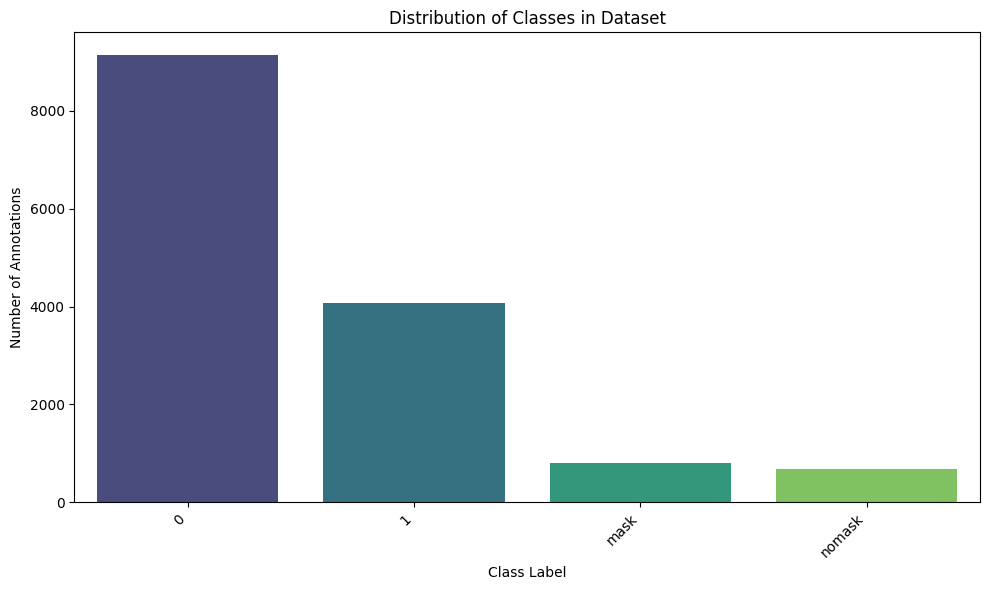

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Annotations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

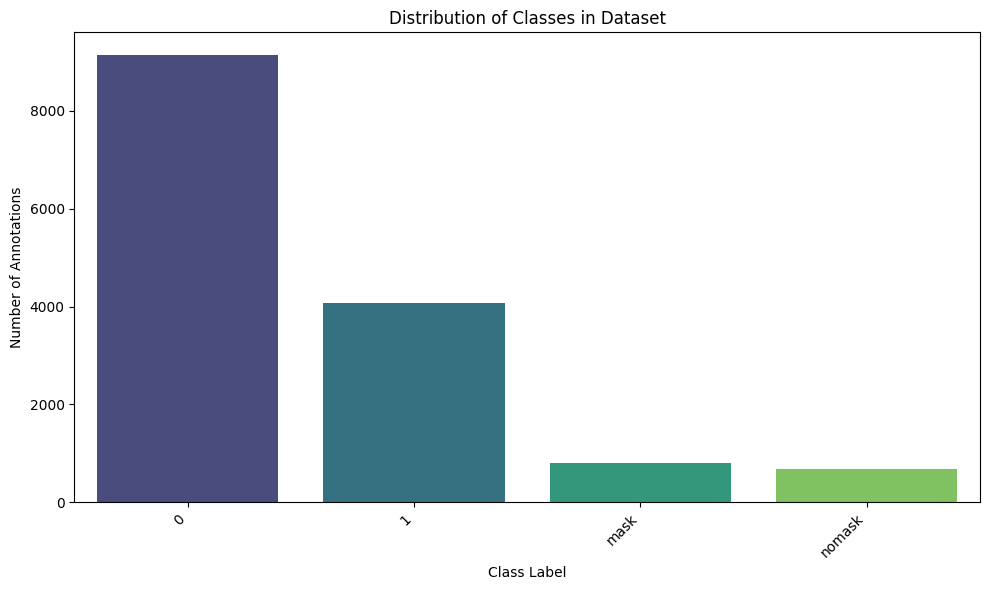

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis', hue=class_distribution.index, legend=False)
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Annotations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
train_images_dir = dataset_dirs['train']
train_labels_dir = Path(str(train_images_dir).replace('images', 'labels'))

all_train_images = [f for f in train_images_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']]

sample_images = []
num_samples = 5

while len(sample_images) < num_samples:
    if not all_train_images:
        print("Error: No images found in the training directory.")
        break

    # Randomly pick an image
    random_image_path = random.choice(all_train_images)

    # Construct the corresponding label file path
    label_filename = random_image_path.stem + '.txt'
    label_filepath = train_labels_dir / label_filename

    # Check if the label file exists
    if label_filepath.exists():
        sample_images.append({'image_path': random_image_path, 'label_path': label_filepath})
        # Remove the selected image from the pool to avoid re-selecting the same image
        all_train_images.remove(random_image_path)
    else:
        print(f"Warning: Skipping {random_image_path} as no corresponding label file was found.")
        # Optionally remove from all_train_images to avoid trying it again
        all_train_images.remove(random_image_path)

print(f"Selected {len(sample_images)} image-label pairs for visualization:")
for item in sample_images:
    print(f"  Image: {item['image_path']}\n  Label: {item['label_path']}")

Selected 5 image-label pairs for visualization:
  Image: face-mask-1/train/images/nomask-390-_jpg.rf.d6f864be882e28a33e6080d5660b1f9f.jpg
  Label: face-mask-1/train/labels/nomask-390-_jpg.rf.d6f864be882e28a33e6080d5660b1f9f.txt
  Image: face-mask-1/train/images/19_Couple_Couple_19_630_jpg.rf.d87bcbc05125f56b3d17638b1185819a.jpg
  Label: face-mask-1/train/labels/19_Couple_Couple_19_630_jpg.rf.d87bcbc05125f56b3d17638b1185819a.txt
  Image: face-mask-1/train/images/test_00003687_jpg.rf.c3a0026858d94c6b4a473f616cd75cb5.jpg
  Label: face-mask-1/train/labels/test_00003687_jpg.rf.c3a0026858d94c6b4a473f616cd75cb5.txt
  Image: face-mask-1/train/images/test_00001082_jpg.rf.25027486a551ece2ed458863ac008802.jpg
  Label: face-mask-1/train/labels/test_00001082_jpg.rf.25027486a551ece2ed458863ac008802.txt
  Image: face-mask-1/train/images/test_00002431_jpg.rf.fce1ae2cdb8d845be117ef53e13ba34a.jpg
  Label: face-mask-1/train/labels/test_00002431_jpg.rf.fce1ae2cdb8d845be117ef53e13ba34a.txt


In [ ]:
def plot_boxes_on_image(image_path, label_path, class_names):
    """
    Reads an image and its YOLO format label file, then plots bounding boxes and labels.

    Args:
        image_path (Path): Path to the image file.
        label_path (Path): Path to the YOLO label file.
        class_names (list): List of class names corresponding to class IDs.

    Returns:
        numpy.ndarray: Image with bounding boxes and labels drawn.
    """
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None

    # Convert BGR to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image_rgb.shape

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

                # Convert normalized coordinates to pixel coordinates
                x1 = int((x_center - bbox_width / 2) * w)
                y1 = int((y_center - bbox_height / 2) * h)
                x2 = int((x_center + bbox_width / 2) * w)
                y2 = int((y_center + bbox_height / 2) * h)

                # Draw rectangle
                color = (255, 0, 0) # Red color for bounding box
                thickness = 2
                cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, thickness)

                # Put label text
                label = class_names[class_id] if class_id < len(class_names) else f'Class {class_id}'
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.7
                font_thickness = 2
                text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

                # Ensure text is visible, adjust position if needed
                text_x = x1
                text_y = y1 - 10 if y1 - 10 > text_size[1] else y1 + text_size[1] + 10
                cv2.putText(image_rgb, label, (text_x, text_y), font, font_scale, color, font_thickness, cv2.LINE_AA)

    return image_rgb

print("The 'plot_boxes_on_image' function has been defined.")

The 'plot_boxes_on_image' function has been defined.


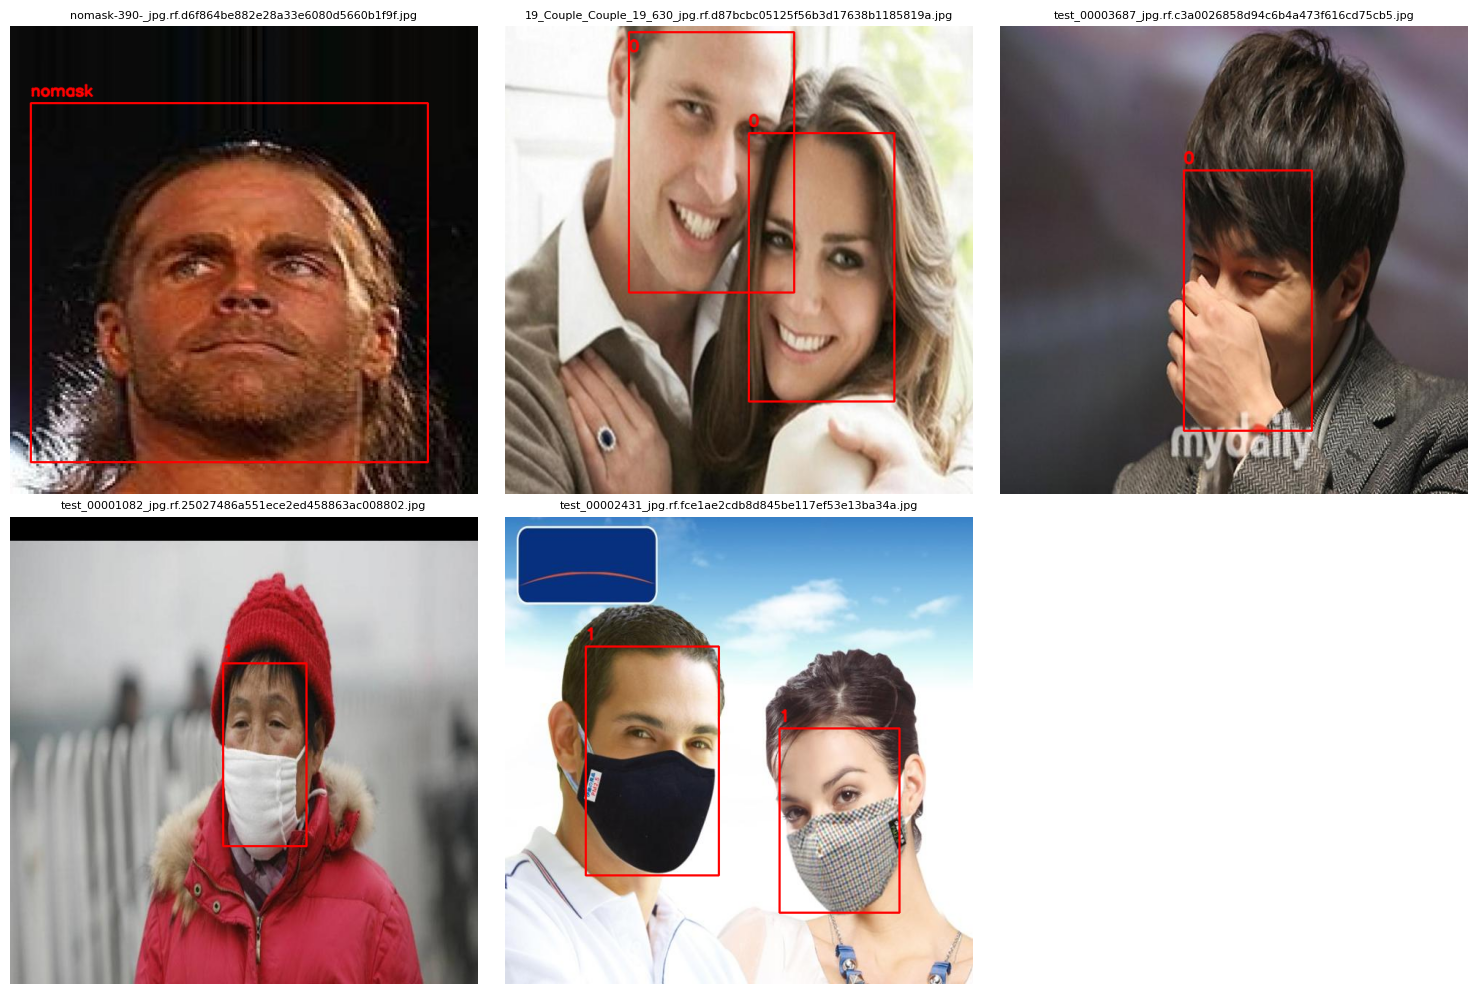

In [ ]:
plt.figure(figsize=(15, 10))
for i, sample in enumerate(sample_images):
    image_with_boxes = plot_boxes_on_image(
        sample['image_path'],
        sample['label_path'],
        class_names
    )

    if image_with_boxes is not None:
        plt.subplot(2, 3, i + 1) # Arrange in 2 rows, 3 columns
        plt.imshow(image_with_boxes)
        plt.title(sample['image_path'].name, fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Original class names: {class_names}")

# Update the class names as specified
class_names[0] = 'nomask'
class_names[1] = 'mask'

print(f"Updated class names: {class_names}")

Original class names: ['0', '1', 'mask', 'nomask']
Updated class names: ['nomask', 'mask', 'mask', 'nomask']


In [ ]:
class_labels = [class_names[idx] for idx in class_counts.index]
class_distribution = pd.Series(class_counts.values, index=class_labels)

print("Class distribution with updated labels:")
print(class_distribution)

Class distribution with updated labels:
nomask    9148
mask      4064
mask       810
nomask     683
dtype: int64


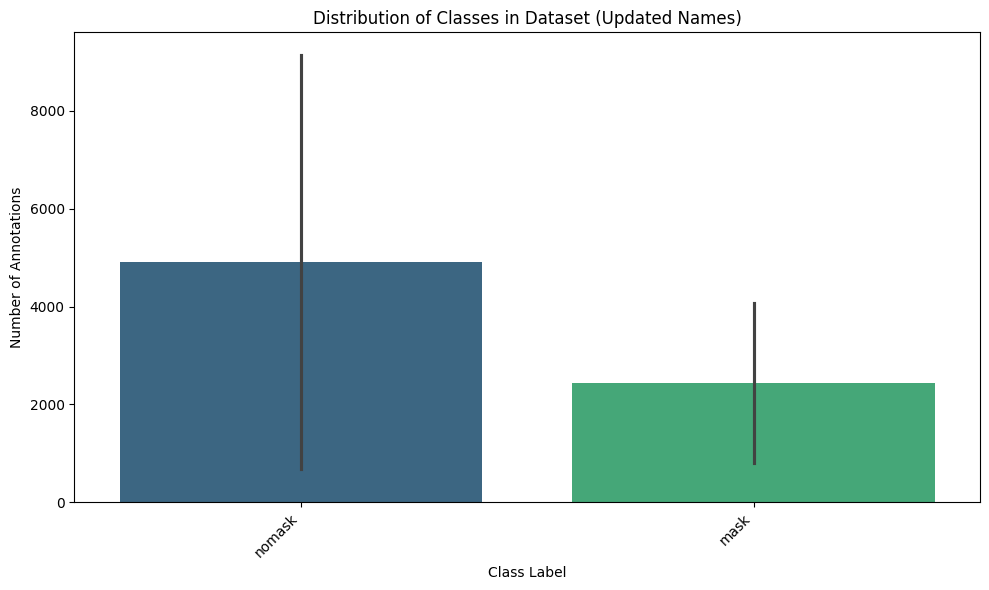

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis', hue=class_distribution.index, legend=False)
plt.title('Distribution of Classes in Dataset (Updated Names)')
plt.xlabel('Class Label')
plt.ylabel('Number of Annotations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
consolidated_class_distribution = class_distribution.groupby(class_distribution.index).sum()

print("Consolidated class distribution:")
print(consolidated_class_distribution)

Consolidated class distribution:
mask      4874
nomask    9831
dtype: int64


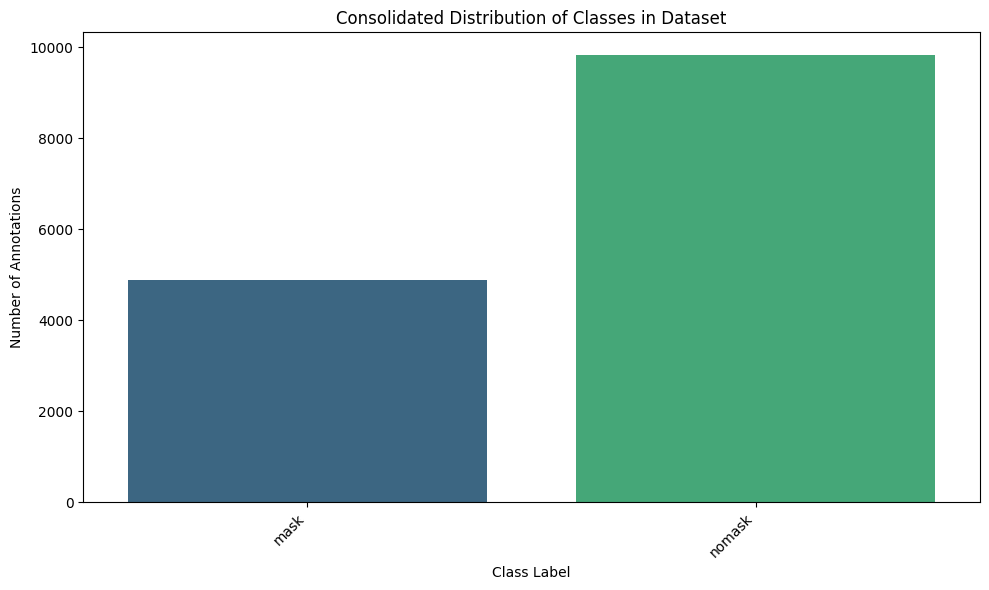

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=consolidated_class_distribution.index, y=consolidated_class_distribution.values, palette='viridis', hue=consolidated_class_distribution.index, legend=False)
plt.title('Consolidated Distribution of Classes in Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Annotations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

print(f"ImageNet Mean: {imagenet_mean}")
print(f"ImageNet Standard Deviation: {imagenet_std}")

ImageNet Mean: [0.485, 0.456, 0.406]
ImageNet Standard Deviation: [0.229, 0.224, 0.225]


In [ ]:
import torch
import torchvision.transforms as transforms

def preprocess_image(image):
    """
    Resizes an image to 224x224, converts it to a PyTorch Tensor,
    and applies ImageNet normalization.

    Args:
        image (PIL.Image or numpy.ndarray): The input image.

    Returns:
        torch.Tensor: The preprocessed and normalized image tensor.
    """
    transform = transforms.Compose([
        transforms.ToPILImage(), # Convert numpy array to PIL Image if necessary
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    return transform(image)

print("The 'preprocess_image' function has been defined.")

The 'preprocess_image' function has been defined.


# **TRAINING SESSION**

In [ ]:
nc = data_yaml['nc']
print(f"Number of classes (nc) from data.yaml: {nc}")

# Initialize a YOLOv8n model (replacing yolov11n as it's not a recognized Ultralytics model)
# The model weights will be downloaded automatically if not found locally
model = YOLO('yolov8n.pt')

print(f"Model initialized: {model.task} with {model.model.nc} classes.")

# Verify that the model's number of output classes matches the nc value
if model.model.nc == nc:
    print(f"Verification successful: Model's output classes ({model.model.nc}) match dataset's classes ({nc}).")
else:
    print(f"Verification failed: Model's output classes ({model.model.nc}) do NOT match dataset's classes ({nc}).")

Number of classes (nc) from data.yaml: 4
Model initialized: detect with 80 classes.
Verification failed: Model's output classes (80) do NOT match dataset's classes (4).


In [ ]:
nc = data_yaml['nc']
print(f"Number of classes (nc) from data.yaml: {nc}")

# Initialize a YOLOv8n model (weights will be downloaded if not found)
model = YOLO('yolov8n.pt')

# Adjust the model's number of output classes to match the dataset's 'nc'
# This is typically handled during the 'train' call, but we can explicitly set it for verification here
model.model.nc = nc
model.model.names = class_names # Update class names for the model

print(f"Model initialized: {model.task} with {model.model.nc} classes.")

# Verify that the model's number of output classes matches the nc value
if model.model.nc == nc:
    print(f"Verification successful: Model's output classes ({model.model.nc}) match dataset's classes ({nc}).")
else:
    print(f"Verification failed: Model's output classes ({model.model.nc}) do NOT match dataset's classes ({nc}).")

Number of classes (nc) from data.yaml: 4
Model initialized: detect with 4 classes.
Verification successful: Model's output classes (4) match dataset's classes (4).


## Configure Training Arguments

### Subtask:
Define the training parameters such as learning rate (`lr0`), number of epochs (`epochs=100`), image size (`imgsz`), momentum (`momentum`), weight decay (`weight_decay`), the chosen optimizer (`optimizer`), and `patience` for early stopping. The `data.yaml` path will also be specified.


**Reasoning**:
I need to define the training parameters as a dictionary named `args` with the specified values, including the `data.yaml` path.



In [ ]:
args = {
    'data': str(data_yaml_path),  # Path to your data.yaml file
    'epochs': 20,
    'imgsz': 640,
    'lr0': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'optimizer': 'auto',  # Let Ultralytics automatically choose the best optimizer
    'patience': 5,       # Early stopping patience
}

print("Training arguments defined:")
for key, value in args.items():
    print(f"  {key}: {value}")

Training arguments defined:
  data: face-mask-1/data.yaml
  epochs: 20
  imgsz: 640
  lr0: 0.01
  momentum: 0.937
  weight_decay: 0.0005
  optimizer: auto
  patience: 5


## Train the Model

### Subtask:
Initiate the training process using the loaded model and the configured training arguments.


**Reasoning**:
I need to initiate the training process by calling the `.train()` method on the `model` object and passing the `args` dictionary as keyword arguments.



In [ ]:
model.train(**args)

Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=face-mask-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pret

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e6e1ede98e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
# Load the best trained model
best_model_path = '/content/runs/detect/train/weights/best.pt'
trained_model = YOLO(best_model_path)

# Run evaluation on the validation set
evaluation_results = trained_model.val()

print("\n--- Model Evaluation Results (from validation set) ---")
print(f"Overall mAP50: {evaluation_results.box.map50:.4f}")
print(f"Overall mAP50-95: {evaluation_results.box.map:.4f}")
# Access the scalar value from the numpy array for precision and recall
print(f"Overall Precision: {evaluation_results.box.p[0]:.4f}")
print(f"Overall Recall: {evaluation_results.box.r[0]:.4f}")

# Access per-class metrics
print("\nPer-Class mAP50:")
for i, class_id_original in enumerate(evaluation_results.ap_class_index):
    # Use the `class_names` from the original data.yaml (updated in previous steps)
    actual_class_label = class_names[class_id_original]
    print(f"  - {actual_class_label}: {evaluation_results.box.maps[i]:.4f}")

Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1310.4±470.3 MB/s, size: 34.3 KB)
val: Scanning /content/face-mask-1/valid/labels.cache... 1811 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1811/1811 3.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 114/114 7.0it/s 16.4s
                   all       1811       3102      0.848      0.934      0.937       0.67
                     0        849       1906      0.911      0.796      0.852       0.57
                     1        719        885      0.935      0.948      0.979      0.761
                  mask        168        168      0.789          1      0.969      0.698
                nomask        143        143      0.758      0.993      0.946       0.65
Speed: 1.1ms preprocess, 3.7ms inference

Displaying predictions on 5 sample images:

Processing image 1/5: 19_Couple_Couple_19_90_jpg.rf.34bc3c2d3e046e4b2741ad0a0242d180.jpg

image 1/1 /content/face-mask-1/test/images/19_Couple_Couple_19_90_jpg.rf.34bc3c2d3e046e4b2741ad0a0242d180.jpg: 640x640 2 0s, 15.3ms
Speed: 3.0ms preprocess, 15.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


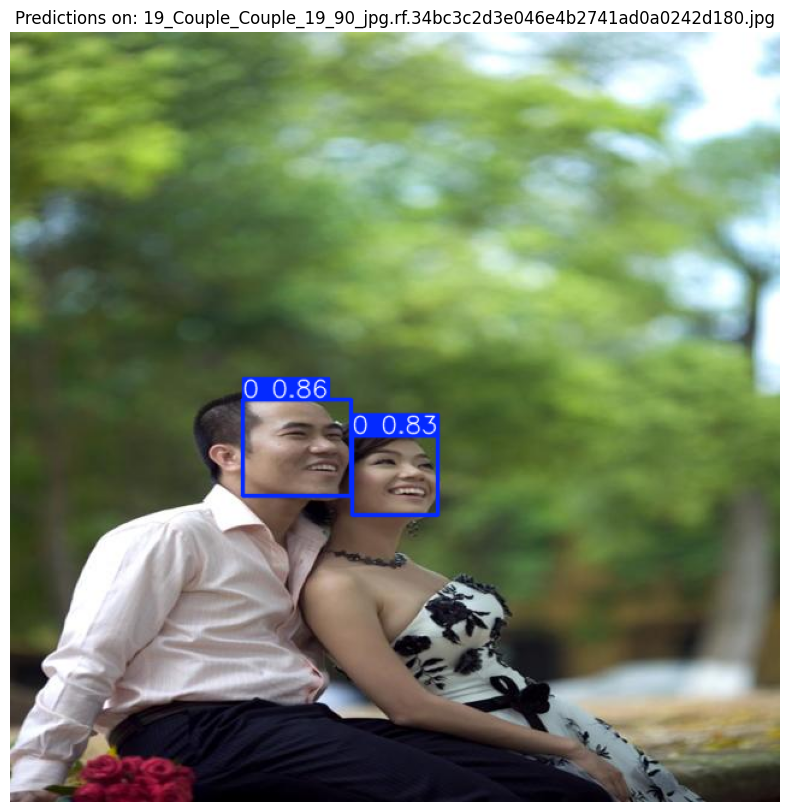


Processing image 2/5: 52_Photographers_taketouristphotos_52_180_jpg.rf.0542b2058cfdbedb255f4a33ae7d95c2.jpg

image 1/1 /content/face-mask-1/test/images/52_Photographers_taketouristphotos_52_180_jpg.rf.0542b2058cfdbedb255f4a33ae7d95c2.jpg: 640x640 4 0s, 1 1, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


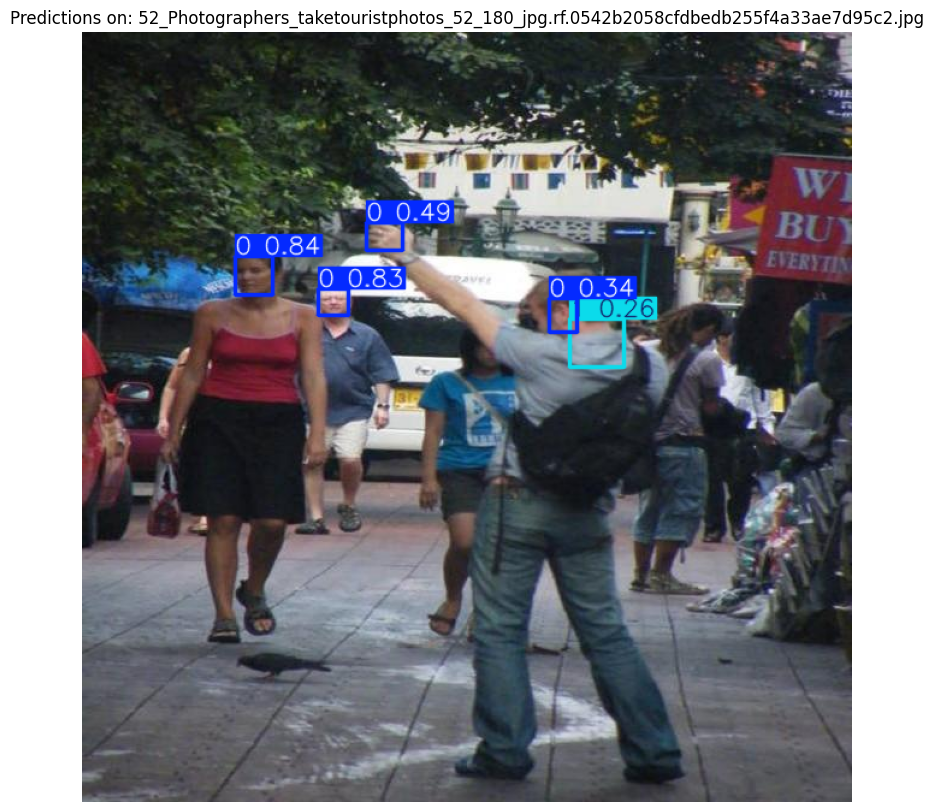


Processing image 3/5: mask-1185-_jpg.rf.b94377958591ba96272d42c0dbd9a6f7.jpg

image 1/1 /content/face-mask-1/test/images/mask-1185-_jpg.rf.b94377958591ba96272d42c0dbd9a6f7.jpg: 640x640 1 mask, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


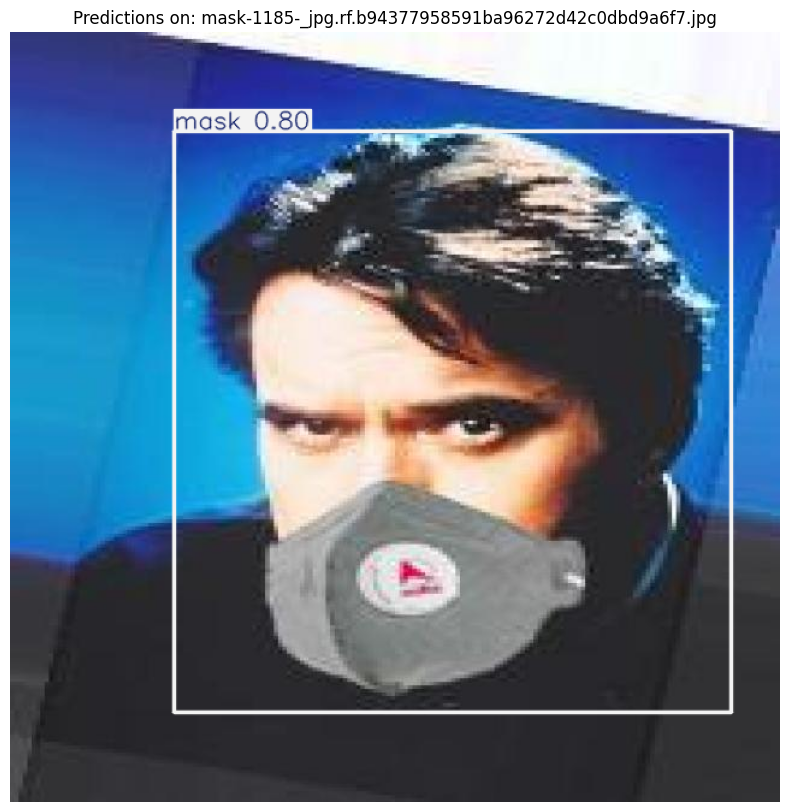


Processing image 4/5: 39_Ice_Skating_Ice_Skating_39_145_jpg.rf.bcc7ac612a54db96b5cdb11e9641c139.jpg

image 1/1 /content/face-mask-1/test/images/39_Ice_Skating_Ice_Skating_39_145_jpg.rf.bcc7ac612a54db96b5cdb11e9641c139.jpg: 640x640 1 0, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


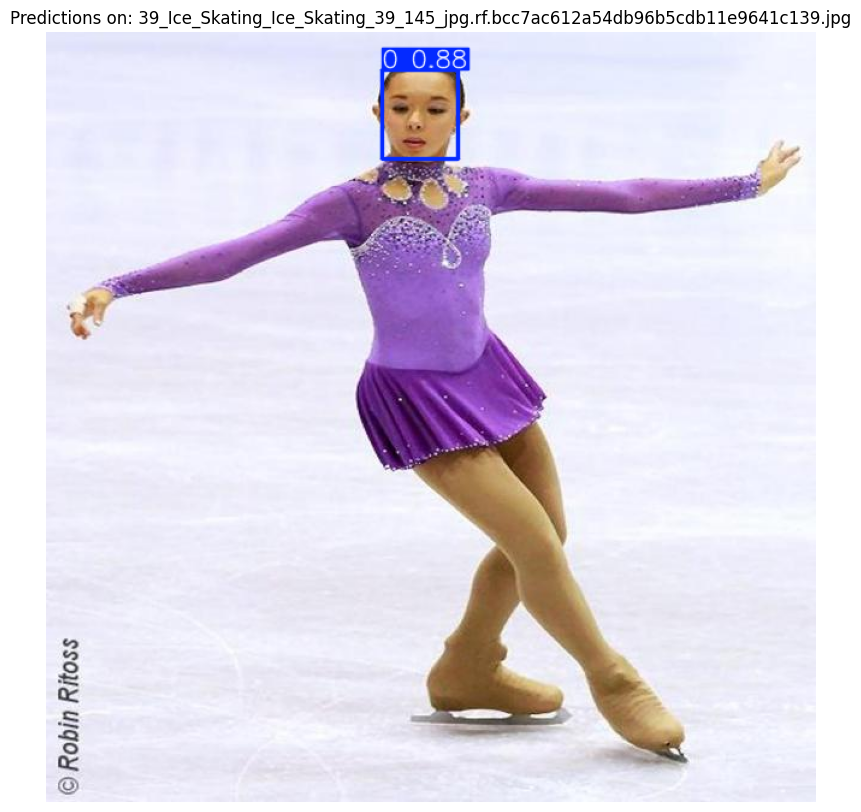


Processing image 5/5: test_00003650_jpg.rf.562bef7a224aac405653628a8c6534e5.jpg

image 1/1 /content/face-mask-1/test/images/test_00003650_jpg.rf.562bef7a224aac405653628a8c6534e5.jpg: 640x640 1 1, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


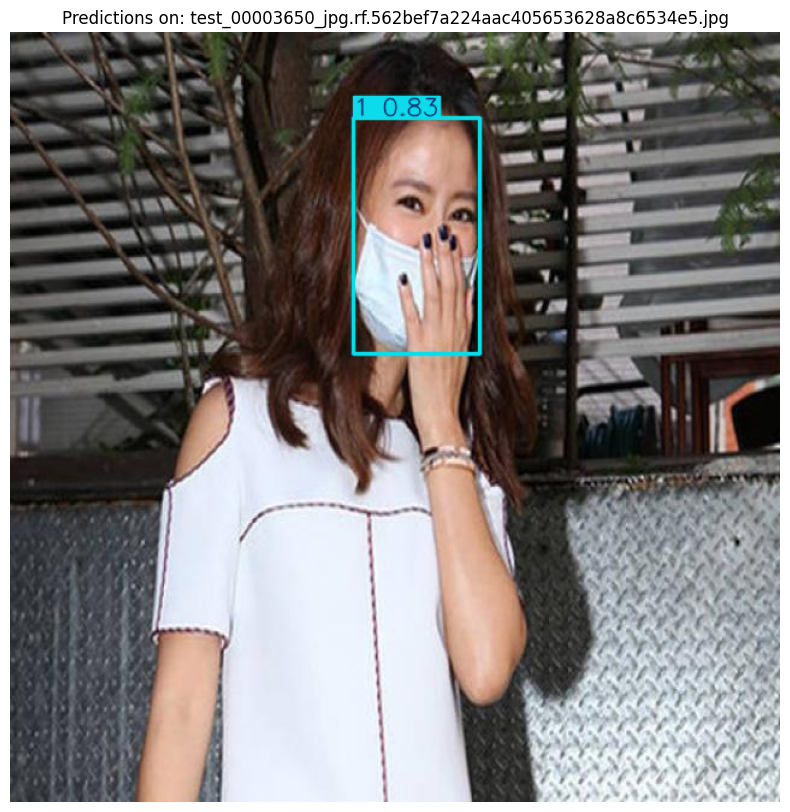

In [ ]:
# Select multiple random images from the test set for prediction visualization
num_sample_images = 5 # Number of random images to display

# Make sure the 'trained_model' is loaded and available
if 'trained_model' not in locals():
    best_model_path = '/content/runs/detect/train/weights/best.pt'
    trained_model = YOLO(best_model_path)

    # Ensure trained_model's names are correctly set from our class_names list
    # This should ideally be handled by YOLO(best_model_path) if names are saved in the model
    # but we can explicitly set it for robustness.
    trained_model.model.names = class_names

# Define all_test_images
test_images_dir = dataset_dirs['test']
all_test_images = [f for f in test_images_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']]

if not all_test_images:
    print("No images found in the test directory.")
else:
    # Ensure we don't try to pick more images than available
    sample_image_paths = random.sample(all_test_images, min(num_sample_images, len(all_test_images)))

    print(f"Displaying predictions on {len(sample_image_paths)} sample images:")

    for i, image_path in enumerate(sample_image_paths):
        print(f"\nProcessing image {i+1}/{len(sample_image_paths)}: {image_path.name}")

        # Run inference on the selected image using the trained_model
        # The 'conf' argument sets the object confidence threshold for detection
        results = trained_model.predict(source=str(image_path), conf=0.25, save=False)

        # Display the result
        for r in results:
            im_array = r.plot()  # plot a BGR numpy array of predictions
            im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB) # convert to RGB for matplotlib
            plt.figure(figsize=(10, 10))
            plt.imshow(im_rgb)
            plt.title(f"Predictions on: {image_path.name}")
            plt.axis('off')
            plt.show()


Saving WhatsApp Image 2025-11-01 at 8.04.37 PM.jpeg to WhatsApp Image 2025-11-01 at 8.04.37 PM.jpeg
User uploaded file "WhatsApp Image 2025-11-01 at 8.04.37 PM.jpeg" with length 137558 bytes

Running prediction on uploaded image: WhatsApp Image 2025-11-01 at 8.04.37 PM.jpeg

image 1/1 /content/WhatsApp Image 2025-11-01 at 8.04.37 PM.jpeg: 480x640 7 0s, 40.1ms
Speed: 2.4ms preprocess, 40.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


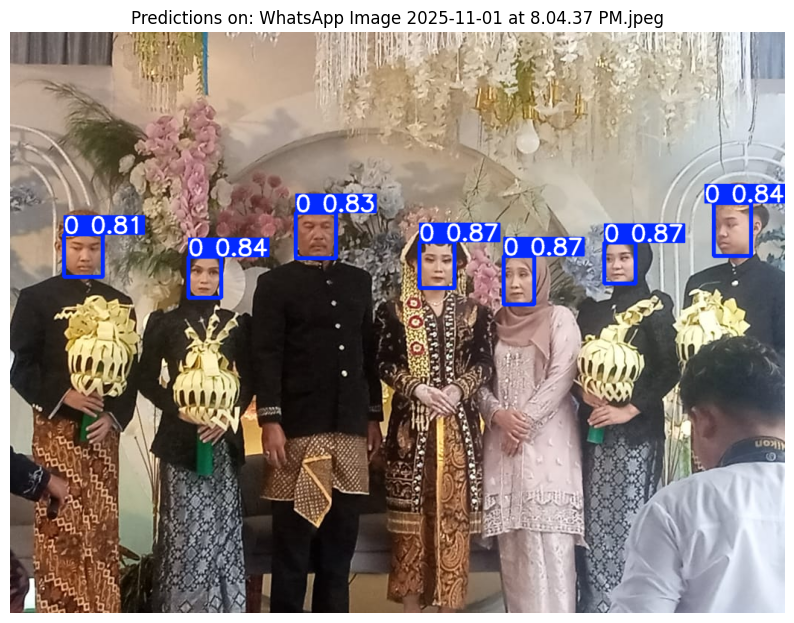

In [ ]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

    # Assuming the user uploads only one image or we take the first one
    uploaded_image_path = filename

    # Run inference on the uploaded image using the trained_model
    print(f"\nRunning prediction on uploaded image: {uploaded_image_path}")
    results = trained_model.predict(source=uploaded_image_path, conf=0.25, save=False)

    # Display the result
    for r in results:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB) # convert to RGB for matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(im_rgb)
        plt.title(f"Predictions on: {uploaded_image_path}")
        plt.axis('off')
        plt.show()

In [ ]:
from google.colab import files

# Path to the best trained model
best_model_path = '/content/runs/detect/train/weights/best.pt'

try:
    files.download(best_model_path)
    print(f"Successfully initiated download for {best_model_path}")
except Exception as e:
    print(f"Error downloading {best_model_path}: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully initiated download for /content/runs/detect/train/weights/best.pt
